# Generative Adversarial Network (GAN)
Since GANs were introduced in 2014 by Google Researcher Ian Goodfellow, the tech has been widely adopted in image generation and transfer. After some early wiry failures, GANs have made huge breakthroughs and can now produce highly convincing fake images of animals, landscapes, human faces, etc. Researchers know what GANs can do, however a lack of transparency in their inner workings means GAN improvement is still achieved mainly through trial-and-error. This allows only limited control over the synthesized images

-------------
## Packages
Let's first import the necessary packages,

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import time

-----
## GPU Device Configuration
Then, we set up and configure our computational devices: 
Whether we use GPU or perform the calculation on CPU.
we use the torch.devices() and torch.cude.is_available() functions to configure our computational devices

In [2]:
#setting up and configuring computational devices
if torch.cuda.is_available():
  dev = "cuda:0" 
else:  
  dev = "cpu"

device = torch.device(dev)
print("Device type in use:",device)

Device type in use: cuda:0
Device type in use: cuda:0


-----
## Configuration
### hyper parameters
We then set up and hyper parameters that need for the our model.
we need to define several hyper parameters for our model:
1. latent size
2. hidden size
3. input image size
4. numbper of epoches
5. batch size
6. out put directory

In [3]:
#defining hyper parameters
latent_size = 128
hidden_size =128
image_size = 2352
epochs = 5
train_batch = 100
test_batch = 100
batch_size = 128 
dir = "output"

Create a directory if not exists
using os.path.exists() to check whether it is exist
using os.makedires to create a directory.

In [4]:
#creating directory
if not os.path.exists(dir):
  os.makedirs(dir)

-----
##  Image processing
Then, we define a image preprocessing object that our dataloader can directly use this object to preprocess our data
We use the pytorch API to preform the data processing.
1. Use transforms.Compose()
2. Use transforms.CenterCrop(160) 
3. Use transforms.Scale(64)


In [5]:
#data preprocessing
transform_1 = transforms.Compose([transforms.CenterCrop(160),transforms.Resize([28,28]),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#adding this will help make code easier later
transform_2 = transform=transforms.Compose([transforms.Resize([28,28]), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

-----
##  Data Loading
Next, we are going to load our data. 
### First, we need to prepare our data:
#### we use the following command to download our data:
1. apt-get install p7zip-full # ubuntu

2. brew install p7zip # Mac

3. python download.py
-----
### We first import necessary librarys for data loading

In [6]:
import numpy as np
import os.path
from glob import glob
from PIL import Image
from tqdm import tqdm
import torchvision.datasets as dset
import torch.utils.data as data

### We first define several helper functions that can help use to load each item in the dataset .
1. We first create a list that contains all image files.    '.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',.

2. We then define a function called is_image_file() which takes the file name as the input:
    <br />a. We 1 if it is a valid image file.
    <br />b. Otherwise we return 0.
    
3. We next define a make_dataset() function which takes a file path as the input:
    <br />a. We go over the path
    <br />b. If it is a valid img file, store it to a list
    <br />c. Return the list
    
4. Finally, we create a function that is called default_loader()
    <br />a. that will open the image and conver it to the RGB using Image.open() and convert()

In [7]:
img_types = ['jpg', 'JPG', 'jpeg', 'JPEG', 'png', 'PNG', 'ppm', 'PPM', 'bmp', 'BMP']

In [8]:
def is_image_file(file_name):
    return any(file_name.endswith(ext) for ext in img_types)

In [9]:
def make_dataset(dir):
    images = []
    for root, _, fnames in sorted(os.walk(dir)):
        for fname in sorted(fnames):
            if is_image_file(fname):
                path = os.path.join(root, fname)
                images.append(path)

    return images

In [10]:
def default_loader(file_path):
    image = Image.open(file_path)
    RGB_image = image.convert(mode="RGB")
    return RGB_image

### We then can use those helper functions to create our dataloader that load each item.  This function is called ImageFloder(data.Dataset) 
1. This function is initlize with root, transform, traget transform and loader
    <br /> a. get all imgs using the correct func we define above
    <br /> b. if no valide imgs: raise an proper error
    <br /> c. print the length of valid data



2. We need to define a __getitem__() function that take index as input
    <br /> a. for the "index" element in the img list
         i. if the transform is not none
             we transform the img using the transofrm
         ii. if the traget transform is not none:
             same.
    <br /> b. return the img and target.




3. We deine a __len__() function that retrun the length of the dataset


In [11]:
class ImageLoader(data.Dataset):
    def __init__(self,root,transform = None,trgt_t = None,loader = default_loader):
        imgs = make_dataset(root)
        self.imgs = imgs
        self.root = root
        self.transform = transform
        self.trgt_t = trgt_t
        self.loader = loader
         
        if len(imgs) == 0:
            raise(RuntimeError("Subfolders of:" + self.root +" have 0 images"))

        print("Found {} images".format(len(self.imgs)))

    def __getitem__(self, index):
        path = self.imgs[index]
        RGB_img = self.loader(path)

        if self.transform != None :
            RGB_img = self.transform(RGB_img)
        if self.trgt_t != None:
            RGB_img = self.trgt_t(RGB_img)
        
        return RGB_img

    def __len__(self):
        return len(self.imgs)

In [12]:
!mkdir celeb && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip

mkdir: cannot create directory ‘celeb’: File exists
mkdir: cannot create directory ‘celeb’: File exists


We then define our data loader get_loader()
This func has 6 arguments
root
split
batch size
scale size
number of workers
shuffle

We first store the return value of os.path.basename of root to a variable
Then we store the path to the image root
1. if the dataset_name is in CelebA:
2. then, we using the ImageFolder object we define above with transform.CenterCrop(160) to store the data
3. otherwise, we do not add the transfrom.CenterCrop when storing the data
Finally, we create a data_loade using torch.utils.data.DataLoader() with proper parameters and set the proper shape of this data_loader using data_loade.shape=?

In [13]:
def get_loader(root,split,batch_size,scale_size,num_workers=2,shuffle=True):
    dataset_name = os.path.basename(root)
    if dataset_name in ["CelebA"]:
        dataset = ImageLoader(root=root, transform=transform_1)

    else: 
        dataset = ImageLoader(root=root, transform=transform_2)
                              
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    
    data_loader.shape = [int(num) for num in dataset[0].size()]

    return data_loader

Then, we use the function above to load the data to the variable

In [14]:

data_loader = get_loader(root = "/home/mmvc/img", split = "train", batch_size = batch_size, scale_size = 64, num_workers=2,shuffle=True )

Found 202599 images
Found 202599 images


-----
##  Network
Next, we are going to design our GAN
We use the pytorch function nn.Sequential() to stack several layers as well as activation functions
### First, we need to create our discriminator
1. We need one input layer, one hidden layers and one out put layer. All of them are defined using nn.Linear() with proper input dim and out dim


2. We adopt nn.LeakyReLU(0.2) as activation layer for the input and hidden layer. 


3. We use nn.Sigmoid() activation function for the output layer

### Next, we are going to define our generator 
1. We need one input layer, one hidden layers and one out put layer. All of them are defined using nn.Linear() with proper input dim and out dim


2. We adopt nn.ReLU() as activation layer for the input and hidden layer. 


3. We use nn.Tanh() activation function for the output layer


#### Please First construct the generator module as follow:
1.	The input of the first linear layer is the latent vector size, output of the first layer is 256
2.	Then followed by a ReLU layer.
3.	The input of the second layer is the 256 and output channel is 512
4.	Followed by the ReLU layer
5.	The input of the third layer is the 512 and output channel is 1024
6.	Followed by the ReLU layer
7.	The input of the fourth layer is the 1024 and output channel is 1024
8.	Followed by the ReLU layer
9.	The input of the final layer is the 1024 and output channel is the image size.
10.	The Tanh is activation function.

#### Please First construct the discriminator module as follow:
1.	The input of the first linear layer is the image size, output of the first layer is 256
2.	Then followed by a LeakyReLU layer.
3.	The input of the second layer is the 256 and output channel is 512
4.	Followed by the leakyReLU layer
5.	The input of the third layer is the 512 and output channel is 512
6.	Followed by the leakyReLU layer
7.	The input of the final layer is the 512 and output channel is 1
8.	The sigmoid is activation function.


In [15]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            nn.Linear(image_size, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [16]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            nn.Linear(latent_size, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 1024),
            nn.ReLU(True),
            nn.Linear(1024, image_size),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)


### Next, we send the network to the target device

In [17]:
gen_net = Generator().to(device)
dis_net = Discriminator().to(device)

if device == 'cuda':
    gen_net = torch.nn.DataParallel(gen_net)
    dis_net = torch.nn.DataParallel(dis_net)
    cudnn.benchmark = True

### Finally, We set the Binary cross entropy loss and optimizer with proper netwrok parameters and learning rates

In [18]:
criterion = torch.nn.BCELoss()
disc_optimizer = torch.optim.Adam(dis_net.parameters(), lr=0.001)
gen_optimizer = torch.optim.SGD(gen_net.parameters(), lr=0.001)
disc_optimizer.zero_grad()
gen_optimizer.zero_grad()

-----
##  Training
Then, we are going to train our Network
### We first starting with two helper function
1. We frist implement the denorm function using clamp() api from pytorch please refer https://pytorch.org/docs/stable/torch.html?highlight=clamp#torch.clamp
2. We define a function that reset all the gradient of the optimziers.

In [19]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [20]:
total_steps = len(data_loader)
print(total_steps)

1583
1583


### Start training
1. we first store the total steps which is equal to the length of data_loader
2. for each epoch
    <br/> a. for each element index and element in the data loader
        i. we reshape the input data to (batch_size，-1) and send to the proper device
        ii. then we create the real and fake labels which are later used as input for the BCE loss using torch.ones(batch_size, 1).to(device) and torch.zeros(batch_size, 1).to(device)
        iii. then we train the descriminator
            A. feedforward and store the predictions of discriminator
            B. compute BCE_Loss using real images and store the loss
            C. random init a latent code z
            D. feedforward and store the predictions of generator
            E. feed the predictions to the descriminator and sotre the prediction
            F. compute BCELoss using fake images and store the loss
            G. perofrm the backprop using losses after that reset the gradient of optimzier.
        iv. then we train the generator
            A. using torch.randn(batch_size, latent_size).to(device) to init a z
            B. feedforward and store the predictions of generator
            C. feed the predictions to the descriminator and sotre the prediction
            D. compute BCE_Loss using real images and store the loss
            F. perofrm the backprop using losses after that reset the gradient of optimzier.
        v. some centain period, we prient the log with proper info
    <br/> b. we store all real image with shape (images.size(0), 1, 28, 28) inoder for the further comparision only once
    <br/> c. we save the fake image with image shape (images.size(0), 1, 28, 28) and denorm() function 
3. Save the model checkpoints using torch.save()


In [21]:
import torchvision.utils as vutils

total_steps = len(data_loader)
generator_loss_list = []
discriminator_loss_list = []
con_img = []

for epoch in range(epochs):
    print("Epoch:",epoch)
    for index,data in enumerate(data_loader):
        if(data.shape[0] == batch_size): # discard the last batch if it is not big enough
            disc_optimizer.zero_grad()
            gen_optimizer.zero_grad()
            lbls_real = torch.ones(batch_size, 1).to(device)
            lbls_fake = torch.zeros(batch_size, 1).to(device)
            l_vector = torch.randn(batch_size,latent_size).to(device)  
            data = data.view(batch_size, -1)
            data = data.to(device)
            out_real_dis= dis_net(data).view(-1)
            r_score = out_real_dis
            out_fake_gen = gen_net(l_vector)
            out_fake_dis = dis_net(out_fake_gen).view(-1)
            f_score = out_fake_dis
            disc_BCE_l_r = criterion(out_real_dis, lbls_real)
            disc_BCE_l_r.backward()
            disc_BCE_l_f = criterion(out_fake_dis, lbls_fake)
            disc_BCE_l_f.backward()
            disc_loss = disc_BCE_l_r + disc_BCE_l_f
            disc_optimizer.step()
            l_vector = torch.randn(batch_size,latent_size).to(device)  
            out_fake_gen = gen_net(l_vector)
            out_fake_dis = dis_net(out_fake_gen).view(-1)
            BCE_loss_real_gen = criterion(out_fake_dis, lbls_real)
            BCE_loss_real_gen.backward()
            gen_optimizer.step()
            generator_loss_list.append(BCE_loss_real_gen.item())
            discriminator_loss_list.append(disc_loss.item())
            print('\nEpoch: {}, Index: {}, GenLoss: {}, DiscLoss: {}'.format(epoch,index,BCE_loss_real_gen.item(), disc_loss.item()))
    
    with torch.no_grad():
        fake = gen_net(l_vector).detach().cpu() # numpy cannot handle GPU tensors
        con_img.append(vutils.make_grid(fake, padding=2, normalize=True)) 

torch.save(gen_net.state_dict(), "generator.pt")
torch.save(dis_net.state_dict(), "discriminator.pt")

Epoch: 0
Epoch: 0

Epoch: 0, Index: 0, GenLoss: 0.7091696262359619, DiscLoss: 1.388810396194458

Epoch: 0, Index: 1, GenLoss: 0.71336430311203, DiscLoss: 1.145243525505066

Epoch: 0, Index: 0, GenLoss: 0.7091696262359619, DiscLoss: 1.388810396194458

Epoch: 0, Index: 1, GenLoss: 0.71336430311203, DiscLoss: 1.145243525505066


/home/mmvc/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/home/mmvc/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



Epoch: 0, Index: 2, GenLoss: 0.7283706068992615, DiscLoss: 0.844229519367218

Epoch: 0, Index: 3, GenLoss: 0.7598692178726196, DiscLoss: 0.6974174976348877

Epoch: 0, Index: 4, GenLoss: 0.8040969967842102, DiscLoss: 0.6417821049690247

Epoch: 0, Index: 5, GenLoss: 0.8627614974975586, DiscLoss: 0.5944939255714417

Epoch: 0, Index: 2, GenLoss: 0.7283706068992615, DiscLoss: 0.844229519367218

Epoch: 0, Index: 3, GenLoss: 0.7598692178726196, DiscLoss: 0.6974174976348877

Epoch: 0, Index: 4, GenLoss: 0.8040969967842102, DiscLoss: 0.6417821049690247

Epoch: 0, Index: 5, GenLoss: 0.8627614974975586, DiscLoss: 0.5944939255714417

Epoch: 0, Index: 6, GenLoss: 0.9461073875427246, DiscLoss: 0.5512332320213318

Epoch: 0, Index: 7, GenLoss: 1.061075210571289, DiscLoss: 0.49867650866508484

Epoch: 0, Index: 6, GenLoss: 0.9461073875427246, DiscLoss: 0.5512332320213318

Epoch: 0, Index: 7, GenLoss: 1.061075210571289, DiscLoss: 0.49867650866508484

Epoch: 0, Index: 8, GenLoss: 1.2125327587127686, Disc

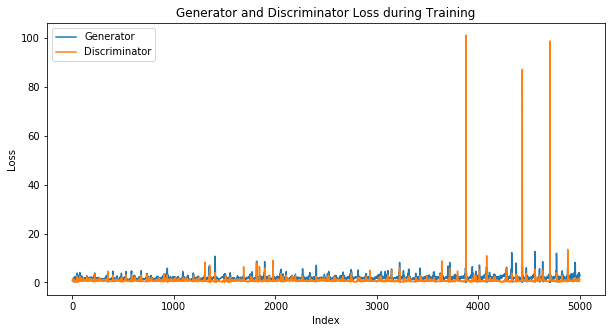

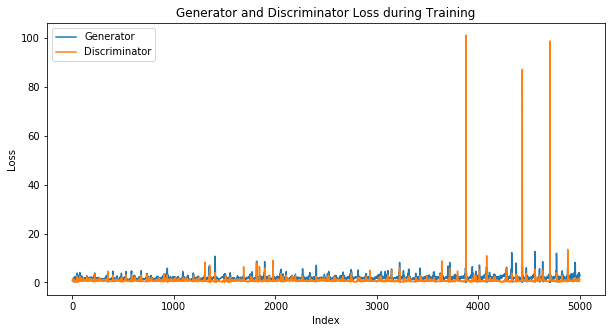

In [26]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss during Training")
plt.plot(generator_loss_list[:5000],label="Generator")
plt.plot(discriminator_loss_list[:5000],label="Discriminator")
plt.xlabel("Index")
plt.ylabel("Loss")
plt.legend()
plt.show()